In [3]:
import pandas as pd
import numpy as np
import pyreadr

from scipy.signal import detrend
from imblearn.ensemble import RUSBoostClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score

In [4]:
pd.set_option('display.max_columns', None)

## Reading the dataset

In [5]:
df = pyreadr.read_r('waterDataTraining.rds')[None].drop('Time', axis=1)
df

,Tp,pH,Cond,Turb,SAC,PFM,Event
0,6.94,8.60774,0.020954,0.125931,3.58683,43.7559,False
1,6.93,8.60589,0.020965,0.127219,3.59025,43.4366,False
2,6.94,8.60220,0.020968,0.126482,3.58318,43.5994,False
3,6.94,8.60220,0.020972,0.126184,3.58769,43.3704,False
4,6.94,8.60405,0.020974,0.127908,3.58287,43.1656,False
...,...,...,...,...,...,...,...
132475,10.30,8.56593,0.020724,0.126518,4.53577,56.4686,False
132476,10.30,8.56593,0.020727,0.126575,4.53008,56.3567,False
132477,10.30,8.56593,0.020723,0.126512,4.53512,55.0477,False
132478,10.30,8.56228,0.020720,0.126477,4.54084,55.4052,False


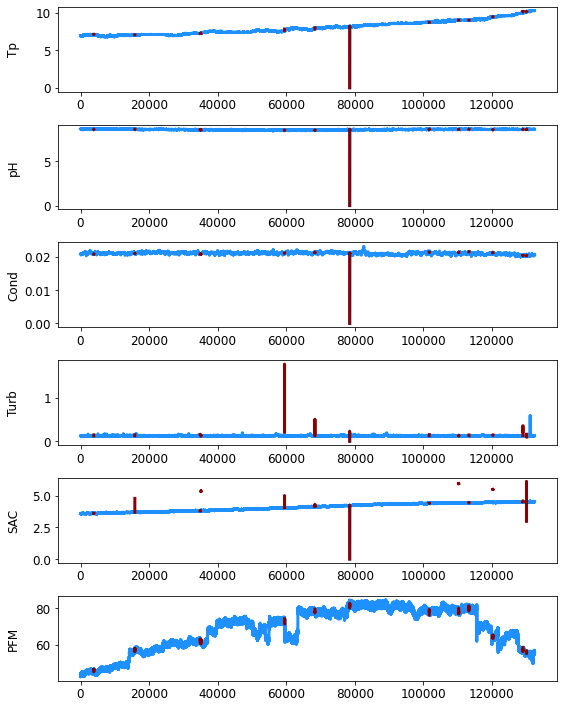

In [17]:
import matplotlib.pyplot as plt
from matplotlib import cm

plt.rc('font', size=12)

fig, ax = plt.subplots(6, 1, figsize=(8,10))

cols = ['Tp', 'pH', 'Cond', 'Turb', 'SAC', 'PFM']
for col in range(len(cols)):
    index = df.index
    
    ax[col].plot(index, np.ma.masked_where(df['Event'], df[cols[col]]), color='dodgerblue', linewidth=3)
    ax[col].plot(index, np.ma.masked_where(~df['Event'], df[cols[col]]), color='darkred', linewidth=3)
    ax[col].set_ylabel(cols[col])
    
fig.align_ylabels()
fig.tight_layout()
plt.savefig('waterquality.png', dpi=300)

## Replicating the steps in the original paper
Monitoring of Drinking-water Quality by Means of a Multi-objective Ensemble Learning Approach, Ribeiro and Reynoso-Meza (2019)

In [5]:
# filling with the average of the past 30 minutes
for index, row in df[df.isna().any(axis=1)].iterrows():
    mean = df.loc[index-30:index-1].mean()
    
    for col in row[row.isna()].index:
        df.loc[index, col] = mean.loc[col]

In [6]:
# detrending using data from the last 24 hours
df_detrend = pd.DataFrame()
for index, row in df.iterrows():
    if index % 10000 == 0:
        display(index)
        
    df_detrend = pd.concat([df_detrend, pd.DataFrame(detrend(df.loc[index-1440:index], axis=0)[-1])], axis=1)
    
df_detrend = df_detrend.T.reset_index(drop=True)
df_detrend.columns = df.columns

0

10000

20000

30000

40000

50000

60000

70000

80000

90000

100000

110000

120000

130000

In [7]:
# feature engineering
diff_1 = df.diff(1)
diff_2 = df.diff(2)
diff_4 = df.diff(4)
diff_8 = df.diff(8)
diff_16 = df.diff(16)
diff_32 = df.diff(32)
mean_30 = df.rolling(30).mean()
sd_30 = df.rolling(30).std()
max_30 = df.rolling(30).max()
min_30 = df.rolling(30).min()

In [8]:
# renaming columns
df_detrend.columns = [col + '_detrend' for col in df_detrend.columns]
diff_1.columns = [col + '_diff_1' for col in diff_1.columns]
diff_2.columns = [col + '_diff_2' for col in diff_2.columns]
diff_4.columns = [col + '_diff_4' for col in diff_4.columns]
diff_8.columns = [col + '_diff_8' for col in diff_8.columns]
diff_16.columns = [col + '_diff_16' for col in diff_16.columns]
diff_32.columns = [col + '_diff_32' for col in diff_32.columns]
mean_30.columns = [col + '_mean_30' for col in mean_30.columns]
sd_30.columns = [col + '_sd_30' for col in sd_30.columns]
max_30.columns = [col + '_max_30' for col in max_30.columns]
min_30.columns = [col + '_min_30' for col in min_30.columns]

In [9]:
# concatenating
df_concat = pd.concat([diff_1.drop('Event_diff_1', axis=1),
                       diff_2.drop('Event_diff_2', axis=1),
                       diff_4.drop('Event_diff_4', axis=1),
                       diff_8.drop('Event_diff_8', axis=1),
                       diff_16.drop('Event_diff_16', axis=1),
                       diff_32.drop('Event_diff_32', axis=1),
                       mean_30.drop('Event_mean_30', axis=1),
                       sd_30.drop('Event_sd_30', axis=1),
                       max_30.drop('Event_max_30', axis=1),
                       min_30.drop('Event_min_30', axis=1),
                       df_detrend.drop('Event_detrend', axis=1),
                       df], axis=1).replace({'Event': {False: 0, True: 1}}).dropna()

In [10]:
# splitting the dataset between train, test and validation
X_train, X_test, y_train, y_test = train_test_split(df_concat.drop('Event', axis=1), df_concat['Event'], test_size=0.4, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [11]:
# training RUSBoost
from sklearn.ensemble import RandomForestClassifier
clf = RUSBoostClassifier(random_state=0, sampling_strategy=1/5, base_estimator=RandomForestClassifier())
clf.fit(X_train, y_train)
f1_score(y_test, clf.predict(X_test))

0.7843137254901961

In [12]:
predictions = np.array([estimator.predict_proba(X_test)[:,1] for estimator in clf.estimators_])

In [15]:
# MOOD
from pymoo.model.problem import Problem
from pymoo.model.repair import Repair
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.algorithms.moead import MOEAD
from pymoo.optimize import minimize
from pymoo.factory import get_problem, get_visualization, get_reference_directions
from random import randint

class RoundRepair(Repair):
    def _do(self, problem, pop, **kwargs):
        # the packing plan for the whole population (each row one individual)
        Z = pop.get("X")
        
        # set the design variables for the population
        if len(Z.shape) == 1:
            Z[:-1] = np.round(Z[:-1])

            if sum(Z[:-1]) == 0:
                index_to_change = randint(0, len(Z)-2)
                Z[index_to_change] = 1
        else:
            Z[:, :-1] = np.round(Z[:, :-1])

            for i in range(Z.shape[0]):
                if sum(Z[i, :-1]) == 0:
                    index_to_change = randint(0, Z.shape[1]-2)
                    Z[i, index_to_change] = 1
                    
        pop.set("X", Z)
        return pop

class MOODProposal(Problem):
    def __init__(self):
        super().__init__(n_var=len(clf.estimators_)+1,
                         n_obj=3,
                         n_constr=2,
                         xl=0.0,
                         xu=1.0)

    def _evaluate(self, X, out, *args, **kwargs):
        y_pred = np.array([np.array(np.where(np.average(predictions, weights=weight[:-1], axis=0) > weight[-1], 1, 0))
                           for weight in X])
        g1 = X[:,-1]-1
        g2 = X[:,-1]*-1
        
        complexity = np.sum(X[:,:-1], axis=1)
        
        fp = np.array([np.sum((pred == 1) & (y_test == 0)) for pred in y_pred])
        tp = np.array([np.sum((pred == 1) & (y_test == 1)) for pred in y_pred])
        fn = np.array([np.sum((pred == 0) & (y_test == 1)) for pred in y_pred])
        tn = np.array([np.sum((pred == 0) & (y_test == 0)) for pred in y_pred])
        
        fpr = fp / (fp + tn)
        fnr = fn / (fn + tp)
        
        out["F"] = np.column_stack([fpr, fnr, complexity])
        out["G"] = np.column_stack([g1, g2])
                        
problem = MOODProposal()

'''
algorithm = NSGA2(pop_size=100,
                  eliminate_duplicates=True,
                  repair=RoundRepair(),
                  seed=0)
'''
algorithm = MOEAD(get_reference_directions("das-dennis", 3, n_partitions=12),
                  n_neighbors=15,
                  decomposition="pbi",
                  prob_neighbor_mating=0.7,
                  eliminate_duplicates=True,
                  repair=RoundRepair(),
                  seed=0)

res = minimize(problem,
               algorithm,
               termination=('n_gen', 50),
               verbose=True)

n_gen |  n_eval |   cv (min)   |   cv (avg)   |  n_nds  |     eps      |  indicator  
    1 |      91 |  0.00000E+00 |  0.00000E+00 |      12 |            - |            -
    2 |     182 |  0.00000E+00 |  0.00000E+00 |      39 |  1.250000000 |        ideal
    3 |     273 |  0.00000E+00 |  0.00000E+00 |      16 |  2.000000000 |        ideal
    4 |     364 |  0.00000E+00 |  0.00000E+00 |      70 |  0.008355388 |        ideal
    5 |     455 |  0.00000E+00 |  0.00000E+00 |      91 |  0.00000E+00 |            f
    6 |     546 |  0.00000E+00 |  0.00000E+00 |      89 |  0.004990548 |        ideal
    7 |     637 |  0.00000E+00 |  0.00000E+00 |      91 |  0.00000E+00 |            f
    8 |     728 |  0.00000E+00 |  0.00000E+00 |      90 |  0.002533081 |        ideal
    9 |     819 |  0.00000E+00 |  0.00000E+00 |      91 |  0.00000E+00 |            f
   10 |     910 |  0.00000E+00 |  0.00000E+00 |      44 |  7.56144E+25 |            f
   11 |    1001 |  0.00000E+00 |  0.00000E+00 |      9

In [16]:
from topsis import topsis

weights = [1/3, 1/3, 1/3]
information = [0, 0, 0]
decision = topsis(res.F, weights, information)
decision

A:\anaconda3\envs\xmoai\lib\site-packages\topsis\topsis.py:66: RuntimeWarning: invalid value encountered in true_divide
  self.r = self.a/np.array(np.linalg.norm(self.a, axis=1)[:, np.newaxis])


Best alternative
a[90]: [6.80529301e-04 0.00000000e+00 8.00000000e+00]

In [17]:
chosen_algorithms = [clf.estimators_[i] for i in range(len(clf.estimators_)) if res.X[decision.optimum_choice][i] == 1]
threshold = res.X[decision.optimum_choice][-1]

class CustomClassifier():
    def __init__(self, chosen_algorithms):
        self.classifiers = chosen_algorithms
        
    def predict_proba(self, X):
        return np.average(np.array([estimator.predict_proba(X) for estimator in self.classifiers]), axis=0)
    
clf = CustomClassifier(chosen_algorithms)

# Generating counterfactuals with XMOAI

In [20]:
from xmoai.setup.configure import generate_counterfactuals_classification_proba

def generate_counterfactuals(chosen_index):
    X_original = X_test.loc[chosen_index, :].values
    y_desired = 1 if y_test.loc[chosen_index] == 0 else 0
    display(f'The desired class is {y_desired}. The current prediction places it at {1 if clf.predict_proba([X_original])[:, 1][0] > threshold else 0} ({clf.predict_proba([X_original])})')

    # as an example, we will be able to only change the *_diff_1 values and the current values
    immutable_column_indexes = [X_test.columns.tolist().index(col) for col
                                in X_test.columns if
                                not col.endswith('_diff_1') and
                                not col.endswith('_detrend') and
                                col not in ['Tp', 'pH', 'Cond', 'Turb', 'SAC', 'PFM']]
    categorical_columns = {} # there are no categorical columns
    integer_columns = [] # there are no columns that only accept integer values
    y_acceptable_range = [threshold if y_desired == 1 else 1-threshold, 1.0] # we will only accept counterfactuals with the predicted prob. in this range

    # limiting the bounds
    #std = X_test.describe().loc['std'].values
    #upper_bounds = X_original + std
    #lower_bounds = X_original - std
    upper_bounds = X_train.max().values # this is the maximum allowed number per column
    lower_bounds = X_train.min().values # this is the minimum allowed number per column.
    
    # running the counterfactual generation algorithm
    front, X_generated, algorithms = generate_counterfactuals_classification_proba(clf,
                          X_original, y_desired, immutable_column_indexes,
                          y_acceptable_range, upper_bounds, lower_bounds,
                          categorical_columns, integer_columns, n_gen=100,
                          pop_size=100, max_changed_vars=10, verbose=False,
                          seed=1, n_jobs=-1)
    
    return front, X_generated, algorithms, X_original

In [25]:
import warnings
warnings.filterwarnings("ignore")

In [26]:
positive_indexes = y_test[y_test==1].index.tolist()
for chosen_index in [12, 13, 14]:
    front, X_generated, algorithms, X_original = generate_counterfactuals(positive_indexes[chosen_index])
    
    df_cfs = pd.concat([pd.DataFrame(X_original).T, pd.DataFrame(X_generated)])
    df_cfs.columns = X_test.columns
    display(df_cfs)

'The desired class is 0. The current prediction places it at 1 ([[0.30409643 0.69590357]])'

,Tp_diff_1,pH_diff_1,Cond_diff_1,Turb_diff_1,SAC_diff_1,PFM_diff_1,Tp_diff_2,pH_diff_2,Cond_diff_2,Turb_diff_2,SAC_diff_2,PFM_diff_2,Tp_diff_4,pH_diff_4,Cond_diff_4,Turb_diff_4,SAC_diff_4,PFM_diff_4,Tp_diff_8,pH_diff_8,Cond_diff_8,Turb_diff_8,SAC_diff_8,PFM_diff_8,Tp_diff_16,pH_diff_16,Cond_diff_16,Turb_diff_16,SAC_diff_16,PFM_diff_16,Tp_diff_32,pH_diff_32,Cond_diff_32,Turb_diff_32,SAC_diff_32,PFM_diff_32,Tp_mean_30,pH_mean_30,Cond_mean_30,Turb_mean_30,SAC_mean_30,PFM_mean_30,Tp_sd_30,pH_sd_30,Cond_sd_30,Turb_sd_30,SAC_sd_30,PFM_sd_30,Tp_max_30,pH_max_30,Cond_max_30,Turb_max_30,SAC_max_30,PFM_max_30,Tp_min_30,pH_min_30,Cond_min_30,Turb_min_30,SAC_min_30,PFM_min_30,Tp_detrend,pH_detrend,Cond_detrend,Turb_detrend,SAC_detrend,PFM_detrend,Tp,pH,Cond,Turb,SAC,PFM
0,0.000000,0.001850,-0.000008,0.001605,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.000039,0.009621,-0.00953,0.1012,7.079,8.556581,0.020824,0.127768,3.612665,45.824697,0.018071,0.004457,0.000013,0.002674,0.005471,0.494293,7.1,8.56476,0.020853,0.136363,3.62418,46.5234,7.04,8.54816,0.020805,0.125853,3.60376,44.4319,0.051068,-0.011581,-0.000012,0.009563,-0.002717,1.123344,7.100000,8.564760,0.020845,0.136363,3.614280,46.523400
0,0.000000,0.001850,-0.000008,-0.003267,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.000039,0.009621,-0.00953,0.1012,7.079,8.556581,0.020824,0.127768,3.612665,45.824697,0.018071,0.004457,0.000013,0.002674,0.005471,0.494293,7.1,8.56476,0.020853,0.136363,3.62418,46.5234,7.04,8.54816,0.020805,0.125853,3.60376,44.4319,-0.041044,0.038496,-0.000012,-0.001527,-0.002717,1.123344,6.837565,8.510871,0.020845,0.123809,3.673941,46.523394
1,0.006393,0.001850,-0.000008,-0.003305,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.000039,0.009621,-0.00953,0.1012,7.079,8.556581,0.020824,0.127768,3.612665,45.824697,0.018071,0.004457,0.000013,0.002674,0.005471,0.494293,7.1,8.56476,0.020853,0.136363,3.62418,46.5234,7.04,8.54816,0.020805,0.125853,3.60376,44.4319,-0.050388,0.039687,-0.000012,-0.001558,-0.002717,1.123344,6.954613,8.599611,0.020845,0.126164,3.642972,46.523400
2,0.000003,0.001850,-0.000008,-0.003267,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.000039,0.009621,-0.00953,0.1012,7.079,8.556581,0.020824,0.127768,3.612665,45.824697,0.018071,0.004457,0.000013,0.002674,0.005471,0.494293,7.1,8.56476,0.020853,0.136363,3.62418,46.5234,7.04,8.54816,0.020805,0.125853,3.60376,44.4319,-0.096479,0.038496,-0.000012,-0.001756,-0.002717,1.123344,6.946536,8.596895,0.020845,0.123875,3.656459,46.514996
3,0.000003,0.001850,-0.000008,-0.001389,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.000039,0.009621,-0.00953,0.1012,7.079,8.556581,0.020824,0.127768,3.612665,45.824697,0.018071,0.004457,0.000013,0.002674,0.005471,0.494293,7.1,8.56476,0.020853,0.136363,3.62418,46.5234,7.04,8.54816,0.020805,0.125853,3.60376,44.4319,-0.103915,0.038496,-0.000012,-0.001829,-0.002717,1.123344,6.991210,8.596895,0.020845,0.123875,3.654925,46.514996
4,-0.000094,0.001850,-0.000008,0.001605,0.003170,0.6174,0.0,0.0,5.000000e-07,0.003196,0.00704,0.0253,0.01,0.00369,0.000004,0.006333,0.00656,0.5184,0.0,0.00369,0.000014,0.009797,0.0018,1.1302,0.02,0.00922,0.000029,0.01003,-0.00724,0.7814,0.06,0.01291,0.0

'The desired class is 0. The current prediction places it at 1 ([[0.3127095 0.6872905]])'

,Tp_diff_1,pH_diff_1,Cond_diff_1,Turb_diff_1,SAC_diff_1,PFM_diff_1,Tp_diff_2,pH_diff_2,Cond_diff_2,Turb_diff_2,SAC_diff_2,PFM_diff_2,Tp_diff_4,pH_diff_4,Cond_diff_4,Turb_diff_4,SAC_diff_4,PFM_diff_4,Tp_diff_8,pH_diff_8,Cond_diff_8,Turb_diff_8,SAC_diff_8,PFM_diff_8,Tp_diff_16,pH_diff_16,Cond_diff_16,Turb_diff_16,SAC_diff_16,PFM_diff_16,Tp_diff_32,pH_diff_32,Cond_diff_32,Turb_diff_32,SAC_diff_32,PFM_diff_32,Tp_mean_30,pH_mean_30,Cond_mean_30,Turb_mean_30,SAC_mean_30,PFM_mean_30,Tp_sd_30,pH_sd_30,Cond_sd_30,Turb_sd_30,SAC_sd_30,PFM_sd_30,Tp_max_30,pH_max_30,Cond_max_30,Turb_max_30,SAC_max_30,PFM_max_30,Tp_min_30,pH_min_30,Cond_min_30,Turb_min_30,SAC_min_30,PFM_min_30,Tp_detrend,pH_detrend,Cond_detrend,Turb_detrend,SAC_detrend,PFM_detrend,Tp,pH,Cond,Turb,SAC,PFM
0,0.000000e+00,-0.003690,-4.000000e-07,0.000068,0.00726,-0.122400,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1837,0.0,-0.00553,-0.000008,0.033725,-0.01608,-0.2606,0.0,-0.00553,-0.000004,0.033311,0.00068,0.7242,0.0,-0.00553,-0.00001,0.033058,0.00127,0.4395,7.250333,8.51384,0.020925,0.133844,3.83431,62.359823,0.001826,0.001675,0.000005,0.013463,0.009147,0.653901,7.26,8.51568,0.020931,0.160378,3.851,63.2186,7.25,8.50831,0.020913,0.125983,3.82089,60.8588,0.008232,-0.012362,-0.000138,0.032442,0.008573,-0.393537,7.250000,8.508310,0.020918,0.160230,3.829920,62.5084
0,0.000000e+00,0.015470,5.251166e-06,0.000068,0.00726,-0.122400,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1837,0.0,-0.00553,-0.000008,0.033725,-0.01608,-0.2606,0.0,-0.00553,-0.000004,0.033311,0.00068,0.7242,0.0,-0.00553,-0.00001,0.033058,0.00127,0.4395,7.250333,8.51384,0.020925,0.133844,3.83431,62.359823,0.001826,0.001675,0.000005,0.013463,0.009147,0.653901,7.26,8.51568,0.020931,0.160378,3.851,63.2186,7.25,8.50831,0.020913,0.125983,3.82089,60.8588,-0.081914,-0.004472,-0.000140,-0.012805,-0.016786,-0.393537,7.250000,8.613843,0.020918,0.123715,3.858692,62.5084
1,9.829168e-03,0.031440,5.179823e-06,0.000068,0.00726,-0.122400,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1837,0.0,-0.00553,-0.000008,0.033725,-0.01608,-0.2606,0.0,-0.00553,-0.000004,0.033311,0.00068,0.7242,0.0,-0.00553,-0.00001,0.033058,0.00127,0.4395,7.250333,8.51384,0.020925,0.133844,3.83431,62.359823,0.001826,0.001675,0.000005,0.013463,0.009147,0.653901,7.26,8.51568,0.020931,0.160378,3.851,63.2186,7.25,8.50831,0.020913,0.125983,3.82089,60.8588,-0.076940,0.023984,-0.000138,-0.002237,-0.018673,-0.393537,7.250000,8.634830,0.020918,0.123833,3.829244,62.5084
2,1.073212e-02,0.005044,-4.000000e-07,0.000068,0.00726,-1.457530,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1837,0.0,-0.00553,-0.000008,0.033725,-0.01608,-0.2606,0.0,-0.00553,-0.000004,0.033311,0.00068,0.7242,0.0,-0.00553,-0.00001,0.033058,0.00127,0.4395,7.250333,8.51384,0.020925,0.133844,3.83431,62.359823,0.001826,0.001675,0.000005,0.013463,0.009147,0.653901,7.26,8.51568,0.020931,0.160378,3.851,63.2186,7.25,8.50831,0.020913,0.125983,3.82089,60.8588,-0.034165,0.017969,-0.000138,-0.005746,-0.017126,-0.393537,7.250000,8.648836,0.020918,0.119873,3.876802,62.5084
3,0.000000e+00,0.015110,-4.000000e-07,0.000068,0.00726,-0.118115,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1837,0.0,-0.00553,-0.000008,0.033725,-0.01608,-0.2606,0.0,-0.00553,-0.000004,0.033311,0.00068,0.7242,0.0,-0.00553,-0.00001,0.033058,0.00127,0.4395,7.250333,8.51384,0.020925,0.133844,3.83431,62.359823,0.001826,0.001675,0.000005,0.013463,0.009147,0.653901,7.26,8.51568,0.020931,0.160378,3.851,63.2186,7.25,8.50831,0.020913,0.125983,3.82089,60.8588,-0.090803,0.007390,-0.000585,-0.002270,-0.042902,-8.639868,7.250000,8.597267,0.020918,0.123502,3.829920,62.5084
4,1.010913e-02,-0.003690,4.985775e-06,0.000068,0.00726,-3.580589,0.0,-0.00369,0.000002,-0.000142,0.00829,1.6496,0.0,-0.00369,-0.000003,-0.000126,-0.01086,-0.1

'The desired class is 0. The current prediction places it at 1 ([[0.3278036 0.6721964]])'

,Tp_diff_1,pH_diff_1,Cond_diff_1,Turb_diff_1,SAC_diff_1,PFM_diff_1,Tp_diff_2,pH_diff_2,Cond_diff_2,Turb_diff_2,SAC_diff_2,PFM_diff_2,Tp_diff_4,pH_diff_4,Cond_diff_4,Turb_diff_4,SAC_diff_4,PFM_diff_4,Tp_diff_8,pH_diff_8,Cond_diff_8,Turb_diff_8,SAC_diff_8,PFM_diff_8,Tp_diff_16,pH_diff_16,Cond_diff_16,Turb_diff_16,SAC_diff_16,PFM_diff_16,Tp_diff_32,pH_diff_32,Cond_diff_32,Turb_diff_32,SAC_diff_32,PFM_diff_32,Tp_mean_30,pH_mean_30,Cond_mean_30,Turb_mean_30,SAC_mean_30,PFM_mean_30,Tp_sd_30,pH_sd_30,Cond_sd_30,Turb_sd_30,SAC_sd_30,PFM_sd_30,Tp_max_30,pH_max_30,Cond_max_30,Turb_max_30,SAC_max_30,PFM_max_30,Tp_min_30,pH_min_30,Cond_min_30,Turb_min_30,SAC_min_30,PFM_min_30,Tp_detrend,pH_detrend,Cond_detrend,Turb_detrend,SAC_detrend,PFM_detrend,Tp,pH,Cond,Turb,SAC,PFM
0,0.000000,0.003670,-0.000003,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021314,0.129029,4.405616,78.45888,5.440576e-07,0.002026,0.000012,0.003103,0.004885,0.803796,8.73,8.55059,0.021341,0.138652,4.41585,79.4204,8.73,8.54509,0.021295,0.126158,4.39496,76.7302,-0.009381,-0.015951,0.000127,0.010604,-0.000425,0.654086,8.730000,8.550590,0.021338,0.138652,4.406540,78.906300
0,-0.219382,0.008210,-0.000003,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021314,0.129029,4.405616,78.45888,5.440576e-07,0.002026,0.000012,0.003103,0.004885,0.803796,8.73,8.55059,0.021341,0.138652,4.41585,79.4204,8.73,8.54509,0.021295,0.126158,4.39496,76.7302,-0.122105,0.036986,-0.000519,-0.007762,0.005210,0.654086,8.730000,8.450107,0.021267,0.120974,4.406540,78.906300
1,-0.016663,0.005827,-0.000003,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021314,0.129029,4.405616,78.45888,5.440576e-07,0.002026,0.000012,0.003103,0.004885,0.803796,8.73,8.55059,0.021341,0.138652,4.41585,79.4204,8.73,8.54509,0.021295,0.126158,4.39496,76.7302,-0.078745,0.014406,-0.000393,-0.001988,0.004608,0.654086,8.730000,8.463154,0.021286,0.120448,4.406540,78.906300
2,0.000000,0.003761,-0.000003,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021314,0.129029,4.405616,78.45888,5.440576e-07,0.002026,0.000012,0.003103,0.004885,0.803796,8.73,8.55059,0.021341,0.138652,4.41585,79.4204,8.73,8.54509,0.021295,0.126158,4.39496,76.7302,-0.329370,0.113135,-0.000172,-0.010006,-0.086994,0.654086,5.189759,8.513222,0.021240,0.122815,4.406540,78.906300
3,0.000000,0.006181,-0.000010,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021314,0.129029,4.405616,78.45888,5.440576e-07,0.002026,0.000012,0.003103,0.004885,0.803796,8.73,8.55059,0.021341,0.138652,4.41585,79.4204,8.73,8.54509,0.021295,0.126158,4.39496,76.7302,-0.233773,0.069871,-0.000320,-0.008342,0.005094,0.654086,8.730000,8.457995,0.021269,0.122226,4.406540,78.906300
4,-0.056415,0.010234,-0.000003,0.001704,-0.003010,-0.048700,0.0,0.0,0.00001,0.003396,0.007,1.5266,0.0,0.0,0.000018,0.007275,0.00148,0.1214,0.0,0.00367,0.000013,0.01153,-0.00075,-0.2685,0.0,0.0055,0.000028,0.01103,0.00379,-0.1706,0.0,-0.00184,0.000039,0.009958,0.00471,0.723,8.73,8.548328,0.021